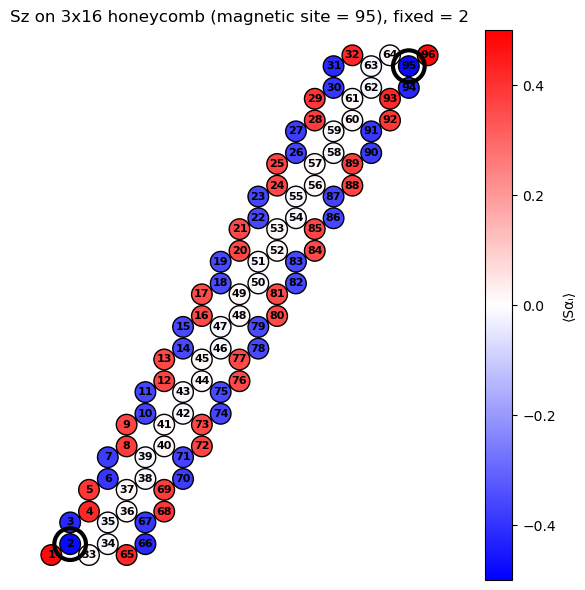

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def honeycomb_bonds(Nx, Ny):
    Nsites = 2 * Nx * Ny
    bonds = []  # (s1, s2, type)
    for i in range(1, Nsites):  # 1..Nsites-1
        if i % 2 == 1:  # odd
            bonds.append((i, i + 1, "xx"))
        else:
            if i <= 2 * Ny * (Nx - 1):
                bonds.append((i, i + 2 * Ny - 1, "yy"))
            if i % (2 * Ny) != 0:
                bonds.append((i, i + 1, "zz"))
    return Nsites, bonds

def honeycomb_positions(Nx, Ny):
    Nsites, bonds = honeycomb_bonds(Nx, Ny)

    a = 1.0
    vx = (np.sqrt(3) * a,  a)   # "xx"
    vy = (np.sqrt(3) * a, -a)   # "yy"
    vz = (0.0,          2 * a)  # "zz"
    vmap = {"xx": vx, "yy": vy, "zz": vz}

    adj = [[] for _ in range(Nsites + 1)]  # 1-indexed
    for s1, s2, bt in bonds:
        v = vmap[bt]
        adj[s1].append((s2, v))
        adj[s2].append((s1, (-v[0], -v[1])))

    pos = np.zeros((Nsites + 1, 2), dtype=float)
    placed = np.zeros(Nsites + 1, dtype=bool)

    # anchor site 1
    pos[1] = (0.0, 0.0)
    placed[1] = True
    queue = [1]

    while queue:
        s = queue.pop(0)
        xs, ys = pos[s]
        for t, v in adj[s]:
            if not placed[t]:
                pos[t] = (xs + v[0], ys + v[1])
                placed[t] = True
                queue.append(t)

    # return 0-indexed array for sites 1..Nsites
    return pos[1:]

def load_component(path):
    with open(path, "r", encoding="utf-8") as f:
        header = f.readline().strip()
    mg_sites = [int(x) for x in header.replace("#", "").split() if x != "i"]

    data = np.loadtxt(path)
    i = data[:, 0].astype(int)
    vals = data[:, 1:]
    return i, vals, mg_sites

def shorten_segment(p1, p2, frac=0.22):
    p1 = np.array(p1, float)
    p2 = np.array(p2, float)
    d = p2 - p1
    return p1 + frac * d, p2 - frac * d

def plot_lattice_values(Nx, Ny, bonds, pos, values,
                        mg_sites=None, mg_site=None,
                        fixed_pos=None, secondspin=False,
                        mark_mg=True, title=""):
    Nsites = 2 * Nx * Ny

    if values.ndim == 2:
        if mg_site is None:
            raise ValueError("Pass mg_site (actual site number) to select a column.")
        if mg_sites is None:
            raise ValueError("mg_sites header list is required when values is 2D.")
        k = mg_sites.index(mg_site)
        v = values[:, k]
    else:
        v = values

    bond_color = {"xx": "blue", "yy": "red", "zz": "green"}

    # --- bonds ---
    for s1, s2, bt in bonds:
        p1 = pos[s1 - 1]
        p2 = pos[s2 - 1]
        p1s, p2s = shorten_segment(p1, p2, frac=0.22)
        plt.plot([p1s[0], p2s[0]], [p1s[1], p2s[1]],
                 lw=2, color=bond_color[bt], alpha=0.8, zorder=1)

    # --- nodes ---
    sc = plt.scatter(pos[:, 0], pos[:, 1], c=v, s=220, edgecolors="k",
                     cmap="bwr", zorder=3, vmin=-0.5, vmax=0.5)
    plt.colorbar(sc, label="⟨Sαᵢ⟩")

    # --- labels ---
    for s in range(1, Nsites + 1):
        plt.text(pos[s - 1, 0], pos[s - 1, 1], str(s),
                 ha="center", va="center", fontsize=8, fontweight="bold", zorder=4)

    # --- mark mg site (thick black ring) ---
    if mark_mg and mg_site is not None:
        plt.scatter([pos[mg_site - 1, 0]], [pos[mg_site - 1, 1]],
                    s=520, facecolors="none", edgecolors="k",
                    linewidths=3, zorder=5)

    # --- mark fixed_pos if secondspin (second ring, different style) ---
    if secondspin and fixed_pos is not None:
        plt.scatter([pos[fixed_pos - 1, 0]], [pos[fixed_pos - 1, 1]],
                    s=520, facecolors="none", edgecolors="k",
                    linewidths=3, zorder=6)

    plt.gca().set_aspect("equal", adjustable="box")
    plt.axis("off")
    if mg_site is None:
        plt.title(title)
    else:
        extra = f" (magnetic site = {mg_site})"
        if secondspin and fixed_pos is not None:
            extra += f", fixed = {fixed_pos}"
        plt.title(f"{title}{extra}")

Nx, Ny = 3, 16
secondspin = True
fixed_pos = 2
component = "Sz"
mg_site = 95
yperiodic = "true"

if secondspin:
    filename = f"{component}_2spins_fixed{fixed_pos}"
else:
    filename = f"{component}"

path = f"results/{Nx}x{Ny}_PBC={yperiodic}/Savrg/{filename}.dat"

Nsites, bonds = honeycomb_bonds(Nx, Ny)
pos = honeycomb_positions(Nx, Ny)

i, vals, mg_sites = load_component(path)

plt.figure(figsize=(8, 6))
plot_lattice_values(
    Nx, Ny, bonds, pos, vals,
    mg_sites=mg_sites, mg_site=mg_site,
    fixed_pos=fixed_pos, secondspin=secondspin,
    title=f"{component} on {Nx}x{Ny} honeycomb"
)
plt.tight_layout()
plt.show()


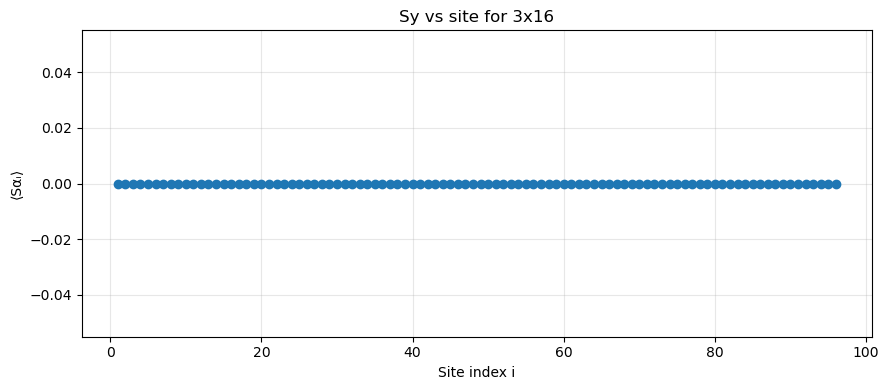

In [30]:
import numpy as np
import matplotlib.pyplot as plt


def load_component(path):
    # header: "# i    2    3   ..."
    with open(path, "r", encoding="utf-8") as f:
        header = f.readline().strip()
    mg_sites = [int(x) for x in header.replace("#", "").split() if x != "i"]

    data = np.loadtxt(path)          # columns: i, col(mg_sites[0]), col(mg_sites[1]), ...
    sites = data[:, 0].astype(int)
    vals = data[:, 1:]
    return sites, vals, mg_sites
def plot_component_vs_site(path, mg_site=None, title=None):
    sites, vals, mg_sites = load_component(path)

    # pick which column to plot
    if mg_site is None:
        k = 0
        mg_site = mg_sites[k]
    else:
        k = mg_sites.index(mg_site)

    y = vals[:, k]

    plt.figure(figsize=(9, 4))
    plt.plot(sites, y, marker="o", linewidth=1)
    plt.xlabel("Site index i")
    plt.ylabel("⟨Sαᵢ⟩")
    plt.title(title or f"{path}   (magnetic site = {mg_site})")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

if secondspin:
    filename = f"{component}_2spins_fixed{fixed_pos}"
else:
    filename = f"{component}"

path = f"results/{Nx}x{Ny}_PBC={yperiodic}/Savrg/{filename}.dat"
plot_component_vs_site(path, mg_site=mg_site, title=f"{component} vs site for {Nx}x{Ny}")
